# Chapter 3. word2vec

Ch.2 에서는 `통계 기반 기법`으로 단어의 분산 표현을 얻었습니다.  
이번 장에서는 `추론 기반 기법`을 살펴보겠습니다.

추론 과정에 신경망을 이용하는데, 여기서 `word2vec`을 사용합니다.  
#### 이번 장의 목표: '단순한' word2vec 구현하기

## 3.1 추론 기반 기법과 신경망  


### 3.1.1. 통계 기반 기법의 문제점

통계 기반 기법은 **대규모 말뭉치**를 다룰 때 문제가 발생  
통계 기반 기법은 말뭉치 전체의 통계를 이용해 단 1회의 처리만에 단어의 분산 표현을 얻습니다.  
추론 기반 기법에서는, 신경망을 이용하는 경우는 **미니배치로 학습**하는 것이 일반적입니다.  

<img src='./master/images/fig 3-1.png' />

### 3.1.2 추론 기반 기법 개요

<p align="center"><img src="./master/images/fig 3-2.png" width=500 />

위 그림처럼 추론 문제를 풀고 학습하는 것이 `추론 기반 기법`이 다루는 문제

<p align="center"><img src="./master/images/fig 3-3.png" width=500>

### 3.1.3 신경망에서의 단어 처리

1. 단어를 '고정 길이의 벡터'로 변환 $\rightarrow$ `원핫 벡터` 로 변환  
2. 신경망을 구성하는 '계층'들은 벡터를 처리할 수 있다. $\rightarrow$ 단어를 신경망으로 처리할 수 있게됨  

<p align="center"><img src="./master/images/fig 3-7.png" width=500 />

In [1]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력
W = np.random.randn(7, 3) # 가중치
h = np.matmul(c, W)
print(h)

[[ 0.65261928 -0.40796078  0.88458879]]


In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[1.14087741 1.78421055 0.12346721]]


## 3.2 단순한 word2vec

<img src="./master/images/fig 3-3.png">

위 그림의 `모델`을 신경망으로 구축해보자!

이번 절에서는 모델로 `CBOW(Continuous bag-of-words)` 를 사용

### 3.2.1 CBOW 모델의 추론 처리

<p align="center"><img src="./master/images/fig 3-9.png" width=500 />

- `CBOW`의 입력 : '맥락'을 원핫 벡터로 변환한 벡터
- 위에서 입력층이 2개인 이유는 `window_size` 가 1이기 때문에 (맥락으로 고려할 단어가 2개)
- `CBOW`의 출력 : 각 단어의 '점수'. 값이 높을수록 대응 단어의 출현 확률이 높아진다. 
- $W_{in}$ : 해당 단어의 분산 표현이 담겨있음

In [4]:
# CBOW 모델의 추론 처리 구현
import sys 
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.rand(7, 3)
W_out = np.random.rand(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파 
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[0.64326783 0.83863979 0.44822332 0.58972759 0.79366845 0.40870303
  0.64941756]]


### 3.2.2 CBOW 모델의 학습

<img src="./master/images/fig 3-12.png" width=400 align='left'/><img src="./master/images/fig 3-13.png" width=450 align='right'/>

- 추론 처리를 수행하는 `CBOW` 모델에 `Softmax` 와 `Cross Entropy Error` 계층을 추가

### 3.2.3 word2vec의 가중치와 분산 표현

- 단어의 분산 표현으로 $W_{in}$ 만을 사용

## 3.3 학습 데이터 준비

### 3.3.1 맥락과 타깃

- `타깃` : 맥락에 둘러싸인 중앙의 단어

#### 1. 말뭉치 텍스트를 단어 ID로 변환

In [5]:
import sys 
sys.path.append('..')
from common.util import preprocess

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print()
print(id_to_word)

[0 1 2 3 4 1 5 6]

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


#### 2. corpus로부터 `맥락`과 `타깃`을 생성

In [7]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = [] 
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [8]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)
print()
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]

[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환

#### 3. 단어 ID를 원핫 벡터로 변환

In [9]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현 (2차원 또는 3차원 넘파이 배열)
    '''
    
    N = corpus.shape[0]
    
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
            
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
                
    return one_hot

In [10]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [11]:
print(target)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


## 3.4 CBOW 모델 구현

<p align="center"><img src="./master/images/fig 3-19.png" />

In [4]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') # 32비트 부동소수점 
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) / 2
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 3.4.1 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/Users/jungnerd/miniforge3/envs/DFS/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jungnerd/miniforge3/envs/DFS/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jungnerd/miniforge3/envs/DFS/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jungnerd/miniforge3/envs/DFS/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


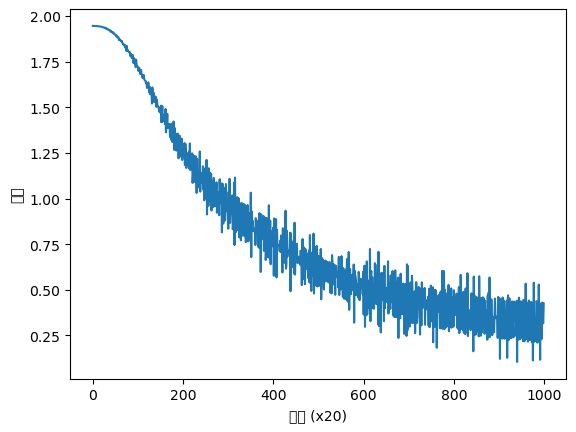

In [1]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [3]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.0244497   0.9493239   1.0007094  -1.7405708  -0.98574144]
say [-1.1556884  -0.42373583 -1.1967598  -1.1419624   1.1924803 ]
goodbye [ 0.97697157  1.005018    0.94898623  0.7959932  -0.96754503]
and [-1.117568   2.140611  -1.1344596 -0.8665194  1.1690147]
i [ 0.9983437   1.0239462   0.9576967   0.77530336 -0.9802986 ]
hello [ 1.0125687  0.9508525  0.984019  -1.7289019 -1.0069677]
. [-0.8419686  -1.7043529  -0.8515892  -1.1874236   0.81978774]


In [4]:
word_vecs

array([[ 1.0244497 ,  0.9493239 ,  1.0007094 , -1.7405708 , -0.98574144],
       [-1.1556884 , -0.42373583, -1.1967598 , -1.1419624 ,  1.1924803 ],
       [ 0.97697157,  1.005018  ,  0.94898623,  0.7959932 , -0.96754503],
       [-1.117568  ,  2.140611  , -1.1344596 , -0.8665194 ,  1.1690147 ],
       [ 0.9983437 ,  1.0239462 ,  0.9576967 ,  0.77530336, -0.9802986 ],
       [ 1.0125687 ,  0.9508525 ,  0.984019  , -1.7289019 , -1.0069677 ],
       [-0.8419686 , -1.7043529 , -0.8515892 , -1.1874236 ,  0.81978774]],
      dtype=float32)

## 3.5 word2vec 보충

### 3.5.1 CBOW 모델과 확률

In [5]:
# TODO : ch03/simple_skip_gram.py 살펴보기
